Analyzing the Dataset

In [1]:
import os

dataset_path = r"E:\Project\Dataset"

# Count image and annotation files
image_extensions = ('.jpg', '.jpeg', '.png')
all_files = os.listdir(dataset_path)
image_files = [f for f in all_files if f.lower().endswith(image_extensions)]
xml_files = [f for f in all_files if f.lower().endswith('.xml')]

# Print basic stats
print(f"📸 Total images: {len(image_files)}")
print(f"📝 Total annotations (XML): {len(xml_files)}")

# Check how many images have a matching annotation
images_with_annots = 0
for img in image_files:
    xml_name = os.path.splitext(img)[0] + ".xml"
    if xml_name in xml_files:
        images_with_annots += 1

print(f" Images with matching annotations: {images_with_annots}")
print(f"Images without annotations: {len(image_files) - images_with_annots}")


📸 Total images: 7053
📝 Total annotations (XML): 7053
 Images with matching annotations: 7053
Images without annotations: 0


Disease classes and their counts

In [2]:
import xml.etree.ElementTree as ET
from collections import Counter

# Initialize a counter to track label frequencies
label_counter = Counter()

# Extract disease labels from each XML file
for xml_file in xml_files:
    xml_path = os.path.join(dataset_path, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    for obj in root.findall('object'):
        label = obj.find('name').text.strip()
        label_counter[label] += 1

# Print unique labels and their counts
print("🦠 Detected disease classes and their counts:\n")
for label, count in label_counter.items():
    print(f"🔹 {label}: {count} annotations")


🦠 Detected disease classes and their counts:

🔹 Apple_scab: 16080 annotations
🔹 Apple_healthy: 1507 annotations
🔹 Apple_Black_rot: 6681 annotations
🔹 Apple_ceder_Apple_rust: 7729 annotations


Generating a data into CSV file

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd
from pathlib import Path
from PIL import Image

dataset_dir = Path(r"E:\Project\Dataset")
project_dir = Path(r"E:\Project")  # <- New line

xml_files = list(dataset_dir.glob("*.xml"))
data = []

for xml_file in xml_files:
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_filename = root.find('filename').text
    image_path = dataset_dir / image_filename

    try:
        image = Image.open(image_path)
        width, height = image.size
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        continue

    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))

        area = (xmax - xmin) * (ymax - ymin)

        data.append({
            'image': str(image_path),
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax,
            'bbox_area': area
        })

df = pd.DataFrame(data)

# Save to Project directory
csv_output_path = project_dir / "annotations.csv"
df.to_csv(csv_output_path, index=False)

print(f" CSV file successfully created: {csv_output_path}")


 CSV file successfully created: E:\Project\annotations.csv


Analyzing the CSV file

In [4]:
import pandas as pd

# Load the annotations CSV
csv_path = r"E:\Project\annotations.csv"
df = pd.read_csv(csv_path)

# Display the first few rows and column info
print("🔹 CSV Preview:")
display(df.head())

print("\n🔹 Column Info:")
df.info()


🔹 CSV Preview:


,image,width,height,class,xmin,ymin,xmax,ymax,bbox_area
0,E:\Project\Dataset\00075aa8-d81a-4184-8541-b69...,256,256,Apple_scab,130,126,164,145,646
1,E:\Project\Dataset\0055dd26-23a7-4415-ac61-e0b...,256,256,Apple_healthy,36,3,226,248,46550
2,E:\Project\Dataset\00907d8b-6ae6-4306-bfd7-d54...,256,256,Apple_healthy,21,19,245,239,49280
3,E:\Project\Dataset\00907d8b-6ae6-4306-bfd7-d54...,256,256,Apple_healthy,22,21,235,239,46434
4,E:\Project\Dataset\0090d05d-d797-4c99-abd4-3b9...,256,256,Apple_Black_rot,221,95,235,102,98



🔹 Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31997 entries, 0 to 31996
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      31997 non-null  object
 1   width      31997 non-null  int64 
 2   height     31997 non-null  int64 
 3   class      31997 non-null  object
 4   xmin       31997 non-null  int64 
 5   ymin       31997 non-null  int64 
 6   xmax       31997 non-null  int64 
 7   ymax       31997 non-null  int64 
 8   bbox_area  31997 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 2.2+ MB


In [5]:
print("Number of unique diseases:", df['class'].nunique())
print("Disease classes:", df['class'].unique())
print("Total number of annotations:", len(df))
print("Total number of unique images:", df['image'].nunique())


Number of unique diseases: 4
Disease classes: ['Apple_scab' 'Apple_healthy' 'Apple_Black_rot' 'Apple_ceder_Apple_rust']
Total number of annotations: 31997
Total number of unique images: 7006


Distribution of bounding box areas

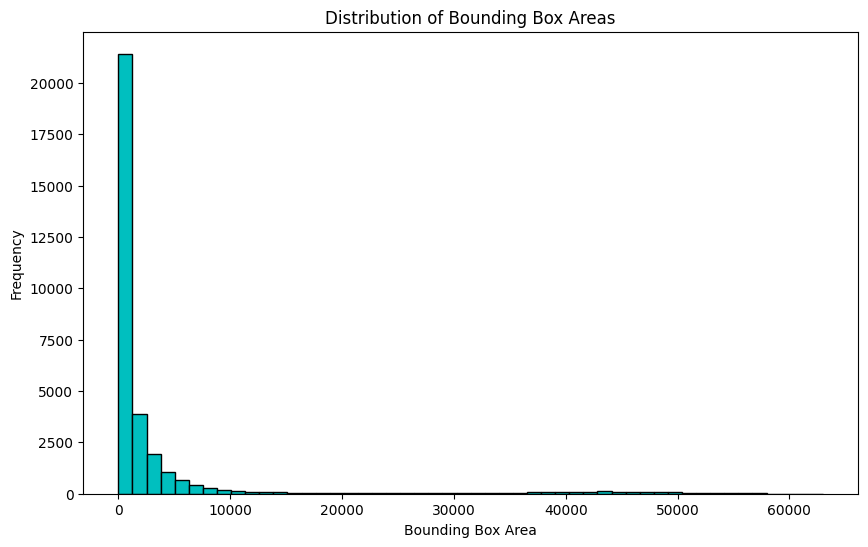

In [6]:
# Plotting the distribution of bounding box areas
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['bbox_area'], bins=50, color='c', edgecolor='black')
plt.title('Distribution of Bounding Box Areas')
plt.xlabel('Bounding Box Area')
plt.ylabel('Frequency')
plt.show()


Distribution of disease classes

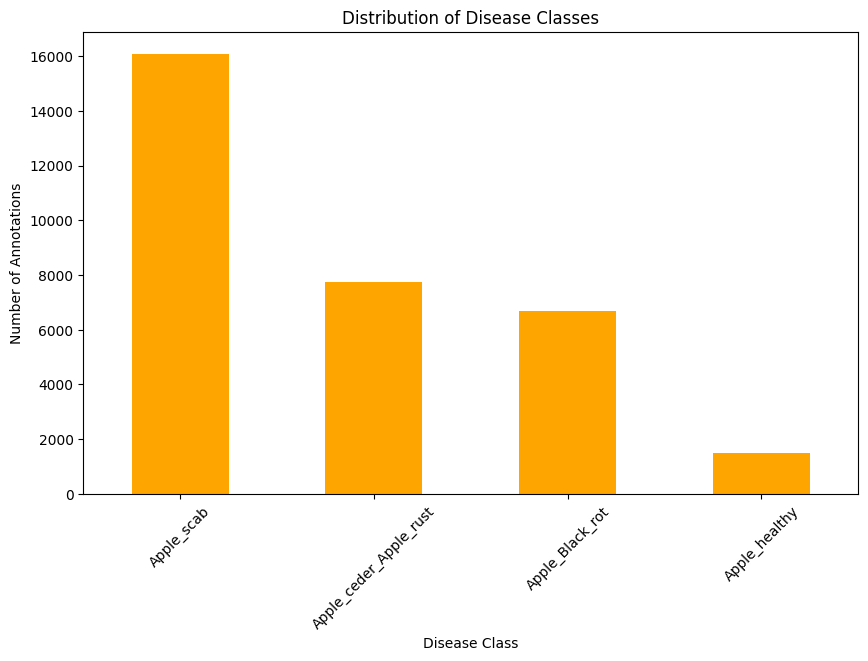

In [7]:
# Plotting the distribution of disease classes
class_counts = df['class'].value_counts()
class_counts.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Distribution of Disease Classes')
plt.xlabel('Disease Class')
plt.ylabel('Number of Annotations')
plt.xticks(rotation=45)
plt.show()


In [8]:
# Check for invalid bounding boxes (where xmin > xmax or ymin > ymax)
invalid_bboxes = df[(df['xmin'] > df['xmax']) | (df['ymin'] > df['ymax'])]
print(f"🔹 Number of invalid bounding boxes: {len(invalid_bboxes)}")


🔹 Number of invalid bounding boxes: 0


Distribution of image dimensions

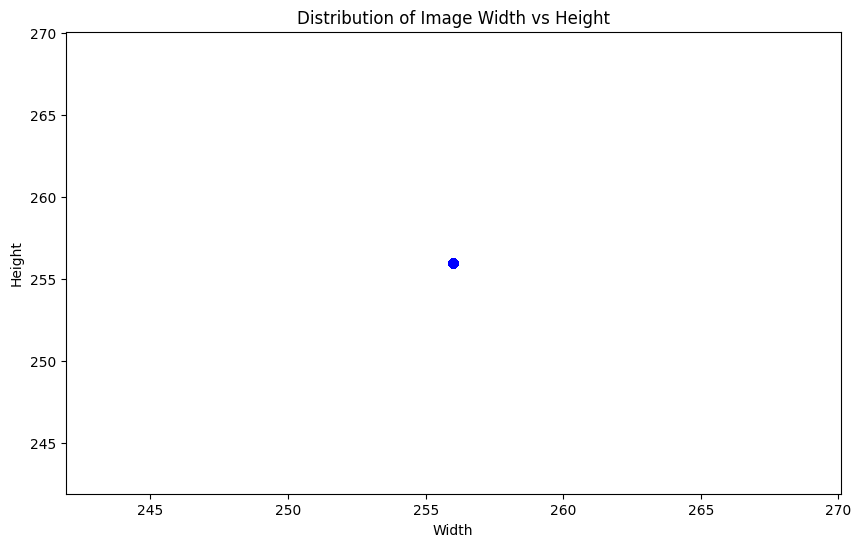

In [9]:
# Plotting the distribution of image dimensions
plt.figure(figsize=(10, 6))
plt.scatter(df['width'], df['height'], alpha=0.5, c='blue')
plt.title('Distribution of Image Width vs Height')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


In [10]:
# Calculate the average number of annotations per image
annotations_per_image = df['image'].value_counts()
avg_annotations_per_image = annotations_per_image.mean()
print(f"🔹 Average number of annotations per image: {avg_annotations_per_image:.2f}")


🔹 Average number of annotations per image: 4.57


In [11]:
# Check for overlapping bounding boxes by comparing the coordinates
overlaps = df.groupby('image').apply(lambda x: len(x) > 1).sum()
print(f"🔹 Number of images with overlapping annotations: {overlaps}")


🔹 Number of images with overlapping annotations: 4015


Severity Analysis Based on Area

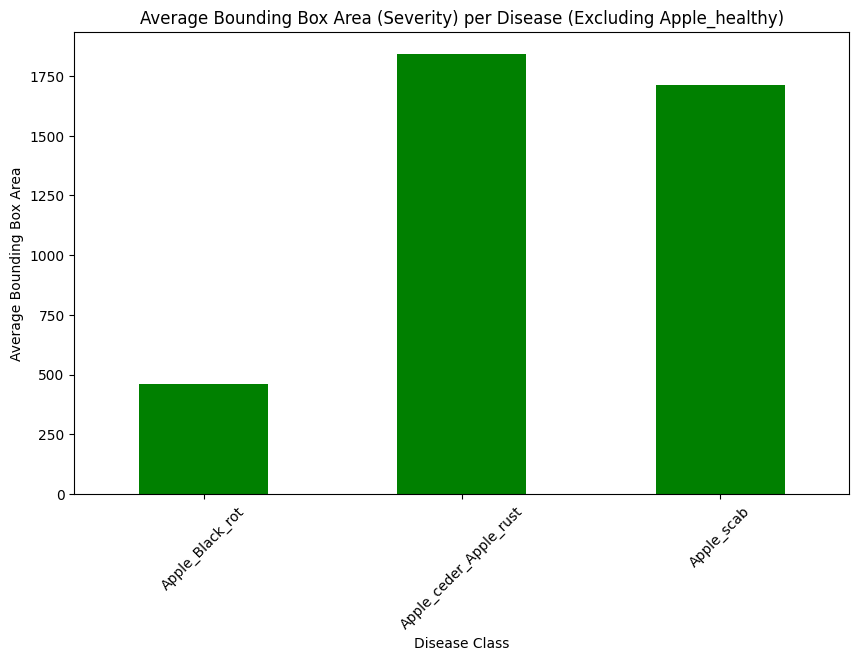

In [12]:
# Exclude 'Apple_healthy' class
df_filtered = df[df['class'] != 'Apple_healthy']

# Analyzing the average bounding box area per disease excluding 'Apple_healthy'
severity_by_disease = df_filtered.groupby('class')['bbox_area'].mean()
severity_by_disease.plot(kind='bar', figsize=(10, 6), color='green')
plt.title('Average Bounding Box Area (Severity) per Disease (Excluding Apple_healthy)')
plt.xlabel('Disease Class')
plt.ylabel('Average Bounding Box Area')
plt.xticks(rotation=45)
plt.show()


Sample image from each Class

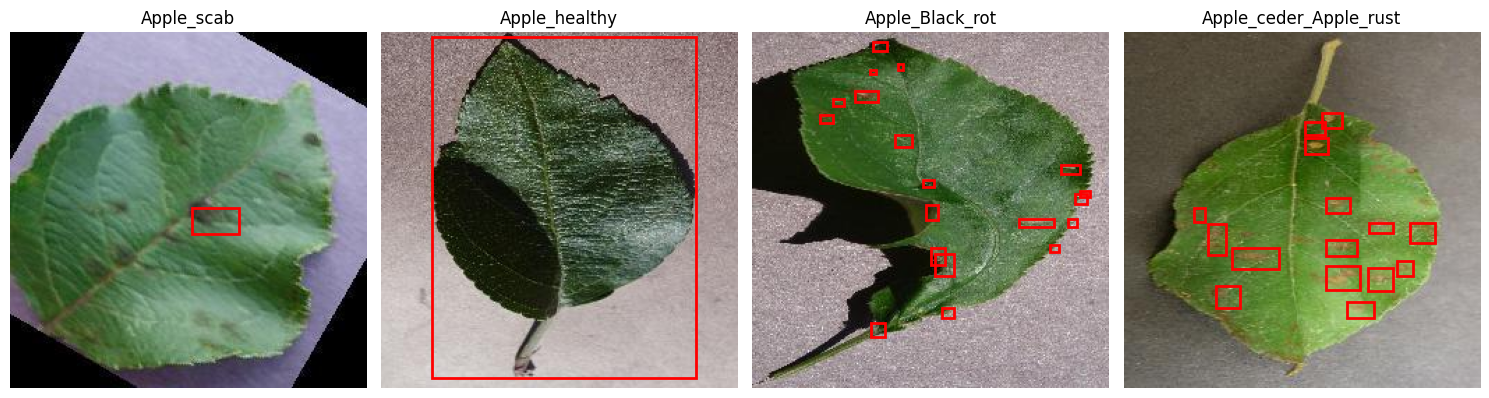

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import random

sample_images = {}
for disease in df['class'].unique():
    sample_image_path = df[df['class'] == disease].iloc[0]['image']
    sample_images[disease] = sample_image_path

# Plot sample images with bounding boxes
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 8))

for ax, (disease, image_path) in zip(axes, sample_images.items()):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_annotations = df[df['image'] == image_path]

    # Plot the image
    ax.imshow(img_rgb)
    ax.set_title(disease)

    # Draw bounding boxes
    for _, row in image_annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.axis('off')

plt.tight_layout()
plt.show()